# Brain Tumor Detection - ResNet50

## ResNet50 Architecture

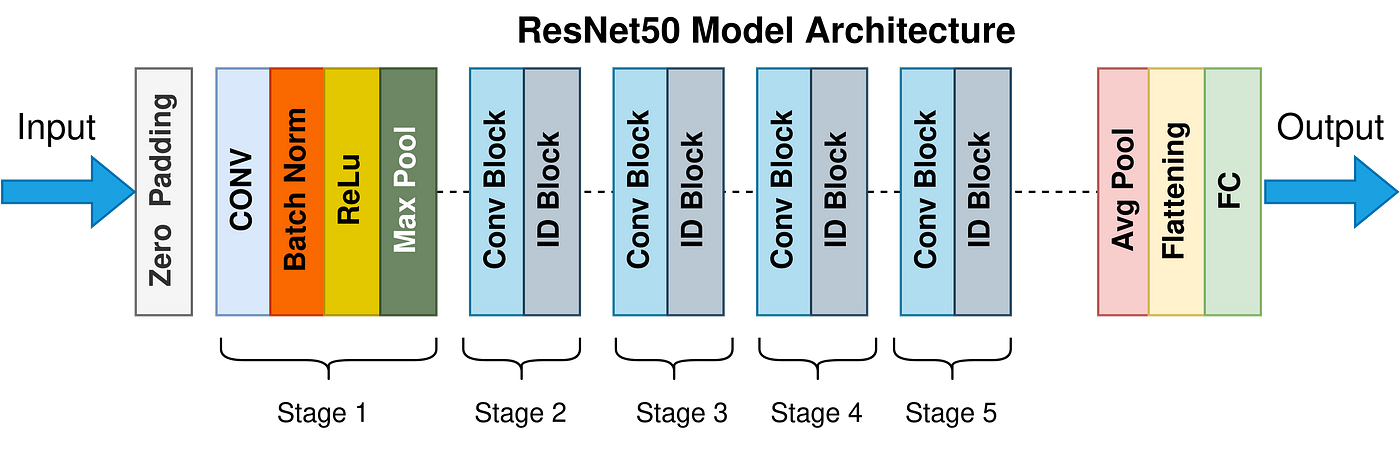

## Import Essential Libraries

In [1]:
# Regular Libraries Imports
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import *
import tensorflow as tf
import keras_tuner as kt
import os
import random
import numpy as np
import cv2
import pandas as pd

# Machine Learning Imports
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt



# Define Constant image size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
IMAGE_SIZE = (IMG_HEIGHT,IMG_WIDTH)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)


# 1. Data Exploration

In [2]:
glioma_images = os.listdir(DATASET_FOLDER + "/glioma")
meningioma_images = os.listdir(DATASET_FOLDER + "/meningioma")
no_tumor_images = os.listdir(DATASET_FOLDER + "/notumor")
pituitary_images = os.listdir(DATASET_FOLDER + "/pituitary")

# Check number of images in each category
print(f"Number of images in each category: Glioma: {len(glioma_images)}, Meningioma: {len(meningioma_images)}, No Tumor: {len(no_tumor_images)}, Pituitary: {len(pituitary_images)}")

Number of images in each category: Glioma: 120, Meningioma: 120, No Tumor: 120, Pituitary: 120


*Since there are equal number of data in each class, we can confirm that there will not be any class dominance.*

## Data Sample from each classes

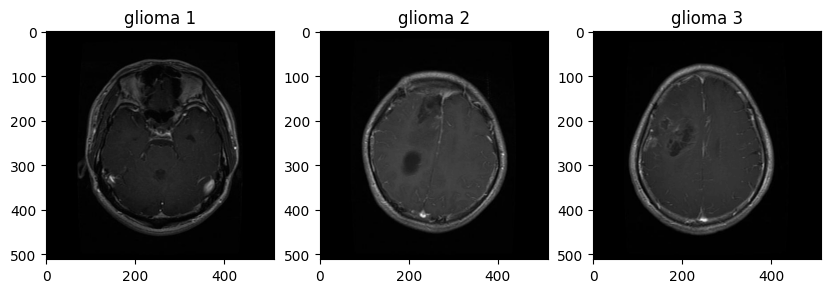

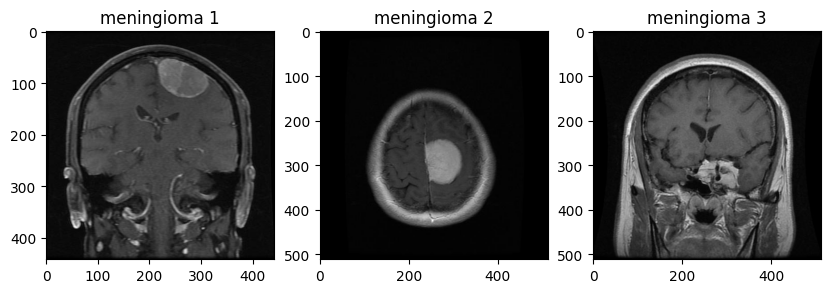

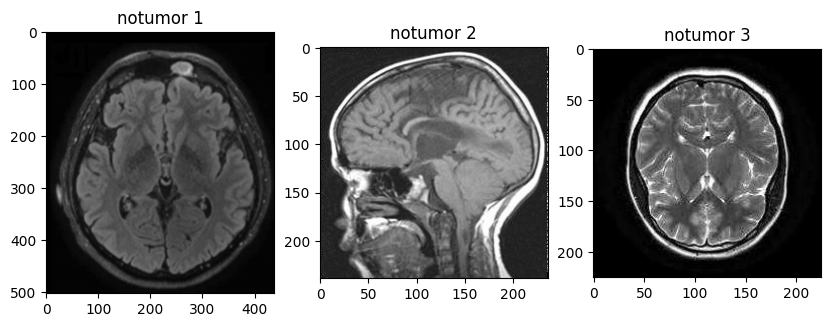

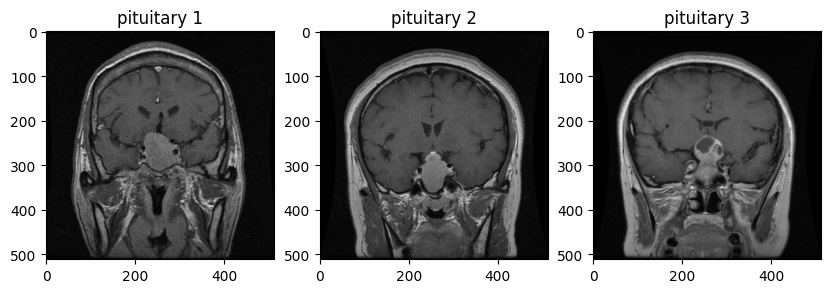

In [3]:
# Function to sample and plot images
def sample_and_plot_images(image_list, category_name, dataset_folder, n=3):
    sampled_images = random.sample(image_list, n)
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(dataset_folder, category_name, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{category_name} {i+1}")
    plt.show()

# Sample and plot images for each category
sample_and_plot_images(glioma_images, "glioma", DATASET_FOLDER)
sample_and_plot_images(meningioma_images, "meningioma", DATASET_FOLDER)
sample_and_plot_images(no_tumor_images, "notumor", DATASET_FOLDER)
sample_and_plot_images(pituitary_images, "pituitary", DATASET_FOLDER)

*Based on the output of the sample images, the scale of each image are in differnet scale. Therefore, rescaling operation has to be done because it standardizes the range of pixel values, making the training process more stable and helping the model converge faster.*

# 2. Data Preparation

Found 480 files belonging to 4 classes.
Using 384 files for training.
Using 96 files for validation.
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']

Training Dataset Preview


2024-07-09 10:59:52.791604: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-09 10:59:52.791631: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-09 10:59:52.791635: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-09 10:59:52.791653: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-09 10:59:52.791664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-07-09 10:59:52.967492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


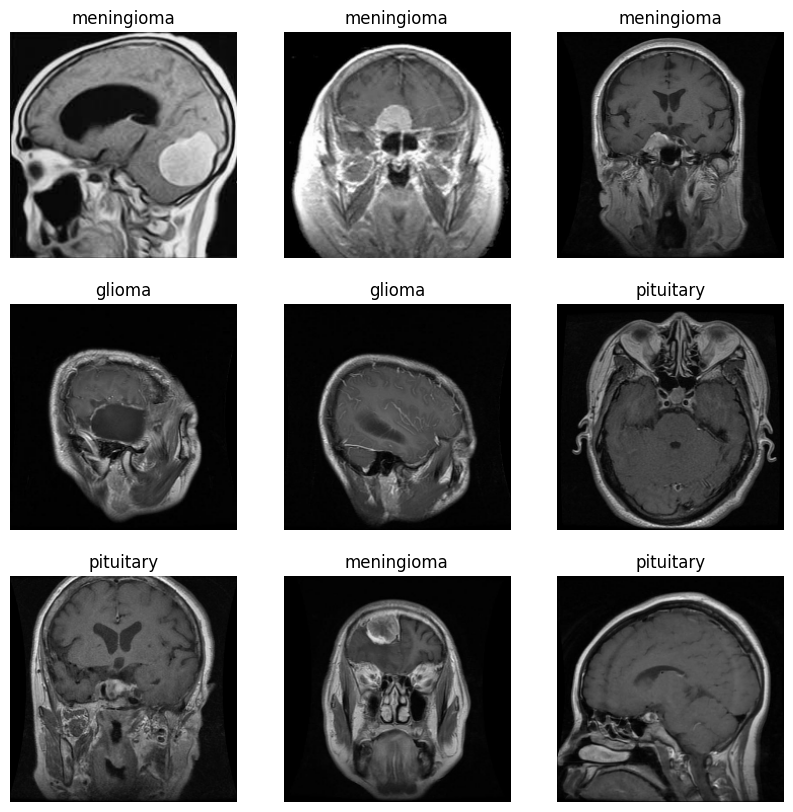

Validation Dataset Preview


2024-07-09 10:59:53.318097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


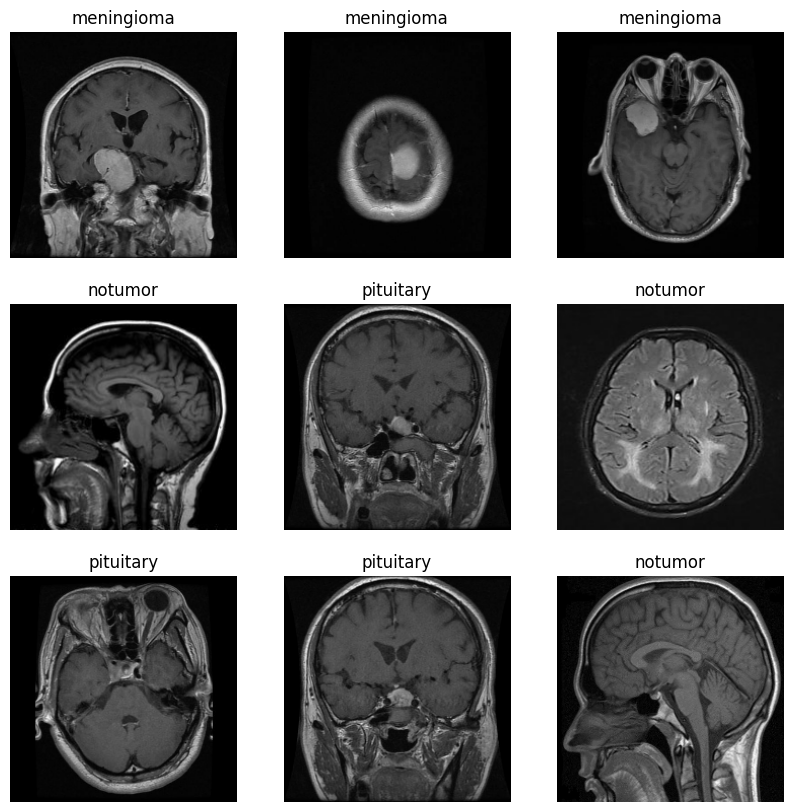

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    subset = "both",
    validation_split = 0.2,
    seed = 42,
    shuffle = True)

class_names = train_ds.class_names
print("Class Names:" , class_names)

# Preview datasets
print("\nTraining Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

print("Validation Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3. Model Building - ResNet50V2
*Improved Version of ResNet50v2*

### 3.1 Finding out the most optimal learning rate

In [6]:
# Load ResNet50V2 base model
base_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False

model = tf.keras.Sequential(layers=[
    #Data Augmentation
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    #Base model and Custom Layer
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="softmax") # 4 classes to classify
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

epochs = 50
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history = model.fit(train_ds,
                     epochs=epochs,
                     validation_data=val_ds,
                     callbacks=[lr_scheduler]
                     )

Epoch 1/50


2024-07-09 10:59:55.695178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 433ms/step - accuracy: 0.2321 - loss: 2.0239 - val_accuracy: 0.5312 - val_loss: 1.1983 - learning_rate: 1.0000e-04
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.4286 - loss: 1.3488 - val_accuracy: 0.6458 - val_loss: 0.9900 - learning_rate: 1.1220e-04
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.4969 - loss: 1.2375 - val_accuracy: 0.7083 - val_loss: 0.8420 - learning_rate: 1.2589e-04
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.5854 - loss: 0.9983 - val_accuracy: 0.6979 - val_loss: 0.7969 - learning_rate: 1.4125e-04
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.5982 - loss: 0.9260 - val_accuracy: 0.7500 - val_loss: 0.7134 - learning_rate: 1.5849e-04
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.7164 - loss: 0.7699 - val_accuracy: 0.7292 - val_loss: 0.7162 - learning_rate: 1.7783e-04
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.7378 - l

Text(0, 0.5, 'val_loss')

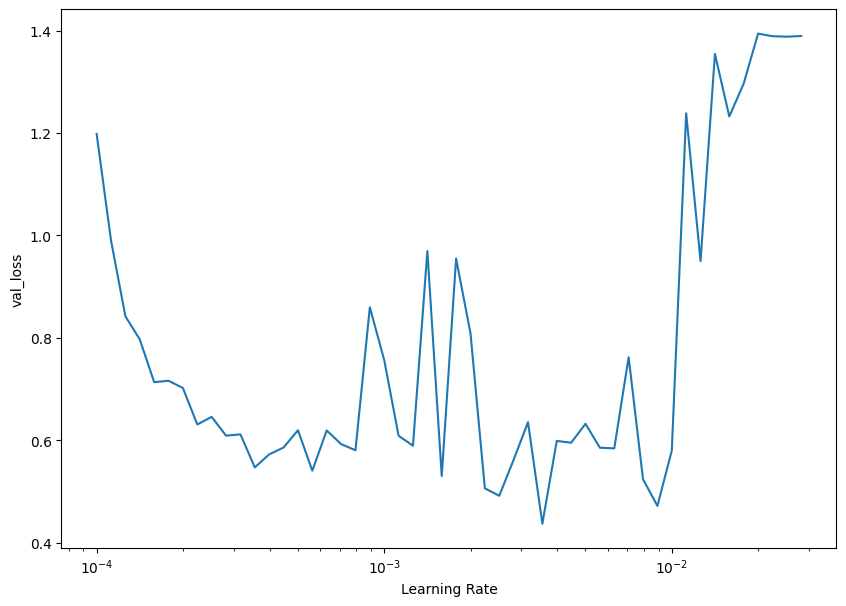

In [7]:
lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history.history['val_loss'])
plt.xlabel('Learning Rate')
plt.ylabel('val_loss')

In [8]:
minimum = min(history.history['val_loss'])
index = history.history['val_loss'].index(minimum)
lr = lrs[index]
print("The better learning rate is", lr)

The better learning rate is 0.003548133892335755


### 3.2 Training the Model with the most optimal learning rate

In [9]:
# Load ResNet50V2 base model
base_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False

model = tf.keras.Sequential(layers=[
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="softmax")
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
               metrics=["accuracy"])

epochs = 50

history = model.fit(train_ds,
                     epochs=epochs,
                     validation_data=val_ds
                     )

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 513ms/step - accuracy: 0.3189 - loss: 5.2856 - val_accuracy: 0.3646 - val_loss: 1.4159
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.4993 - loss: 1.4242 - val_accuracy: 0.6667 - val_loss: 0.8303
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.6392 - loss: 1.0101 - val_accuracy: 0.7292 - val_loss: 0.6434
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.6597 - loss: 0.8375 - val_accuracy: 0.8333 - val_loss: 0.5144
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.7341 - loss: 0.7557 - val_accuracy: 0.7396 - val_loss: 0.5162
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.7595 - loss: 0.5733 - val_accuracy: 0.8021 - val_loss: 0.4660
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.8178 - loss: 0.4890 - val_accuracy: 0.7604 - val_loss: 0.5329
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.7891 - loss: 0.5051 - val_accuracy: 0

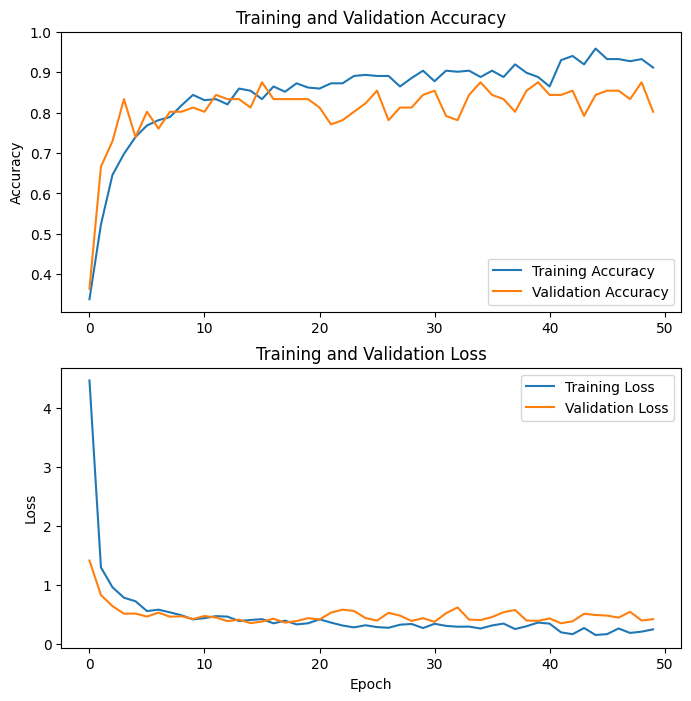

Training Results:
~Accuracy~
Max (best) accuracy: 0.9583333134651184 at epoch 45
Min (worst) accuracy: 0.3385416567325592 at epoch 1
Median accuracy: 0.875
Mean accuracy: 0.8493749958276748

~Loss~
Min (best) loss: 0.15361623466014862 at epoch 45
Max (worst) loss: 4.468405246734619 at epoch 1
Median loss: 0.3419578820466995
Mean loss: 0.46733751237392424

~Final Training Performance~
Accuracy: 0.9713541865348816, Loss: 0.08963633328676224

Validation Results:
~Accuracy~
Max (best) accuracy: 0.875 at epoch 16
Min (worst) accuracy: 0.3645833432674408 at epoch 1
Median accuracy: 0.8333333134651184
Mean accuracy: 0.809791664481163

~Loss~
Min (best) loss: 0.35282012820243835 at epoch 42
Max (worst) loss: 1.4159353971481323 at epoch 1
Median loss: 0.4491962194442749
Mean loss: 0.4864287608861923

~Final Validation Performance~
Accuracy: 0.8020833134651184, Loss: 0.42241740226745605


In [10]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(val_ds, verbose=0)))

## Model Performance

2024-07-09 11:04:31.100184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


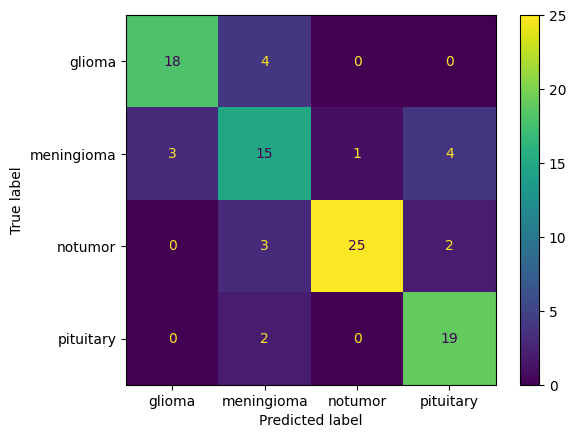

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = []
y_true = []
y_pred = []

predictions = model.predict(val_ds, verbose=0)
for prediction in predictions:
    score = tf.nn.softmax(prediction)
    y_pred.append(np.argmax(score))
    
for X, y in val_ds.as_numpy_iterator():  
    y_true.extend(y)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot()

In [12]:
def metrics2dt(acc, rc, pr, f1):
    return pd.DataFrame(data={"Accuracy":acc, "Recall":rc, "Precision":pr, "F1-Score":f1}, index=[0])

def show_metrics(y_true, y_pred):
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    accuracy = tf.keras.metrics.Accuracy()

    recall.update_state(y_true, y_pred)
    recall = recall.result().numpy()
    
    precision.update_state(y_true, y_pred)
    precision = precision.result().numpy()
    
    accuracy.update_state(y_true, y_pred)
    accuracy = accuracy.result().numpy()
    
    f1_score = 0
    if recall+precision != 0:
        f1_score = 2 * ((recall*precision)/(recall+precision))
    
    return metrics2dt(accuracy, recall, precision, f1_score)

validation_metrics = show_metrics(y_true,y_pred)
validation_metrics

,Accuracy,Recall,Precision,F1-Score
0,0.802083,0.959459,0.946667,0.95302


# Keras Tuner Optimisation

In [13]:
import keras_tuner as kt

def build_model(hp):
    base_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.layers.Resizing(224, 224),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.25),
        tf.keras.layers.RandomZoom(0.05, 0.05),
        tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(hp.Int('units1', min_value=256, max_value=1024, step=128), activation="relu"),
        tf.keras.layers.Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(hp.Int('units2', min_value=128, max_value=512, step=64), activation="relu"),
        tf.keras.layers.Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(4, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    
    return model


In [14]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='resnet50v2_classification',
    project_name='brain_tumor_tuning'
)

Reloading Tuner from my_dir/brain_tumor_tuning/tuner0.json


In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first dense layer is {best_hps.get('units1')}.
The optimal number of units in the second dense layer is {best_hps.get('units2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
The optimal dropout rate for the first dropout layer is {best_hps.get('dropout1')}.
The optimal dropout rate for the second dropout layer is {best_hps.get('dropout2')}.
""")


The optimal number of units in the first dense layer is 512.
The optimal number of units in the second dense layer is 320.
The optimal learning rate is 0.001.
The optimal dropout rate for the first dropout layer is 0.4.
The optimal dropout rate for the second dropout layer is 0.30000000000000004.



Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3689 - loss: 1.6970 - val_accuracy: 0.6771 - val_loss: 0.8353
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - accuracy: 0.6874 - loss: 0.8293 - val_accuracy: 0.7188 - val_loss: 0.6985
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - accuracy: 0.7697 - loss: 0.6936 - val_accuracy: 0.8125 - val_loss: 0.5079
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.8043 - loss: 0.4666 - val_accuracy: 0.8021 - val_loss: 0.4948
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.8444 - loss: 0.3941 - val_accuracy: 0.8125 - val_loss: 0.4927
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.8150 - loss: 0.4595 - val_accuracy: 0.8438 - val_loss: 0.5520
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.8192 - loss: 0.4292 - val_accuracy: 0.8125 - val_loss: 0.5563
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.8284 - loss: 0.4208 - val_accuracy: 0.83

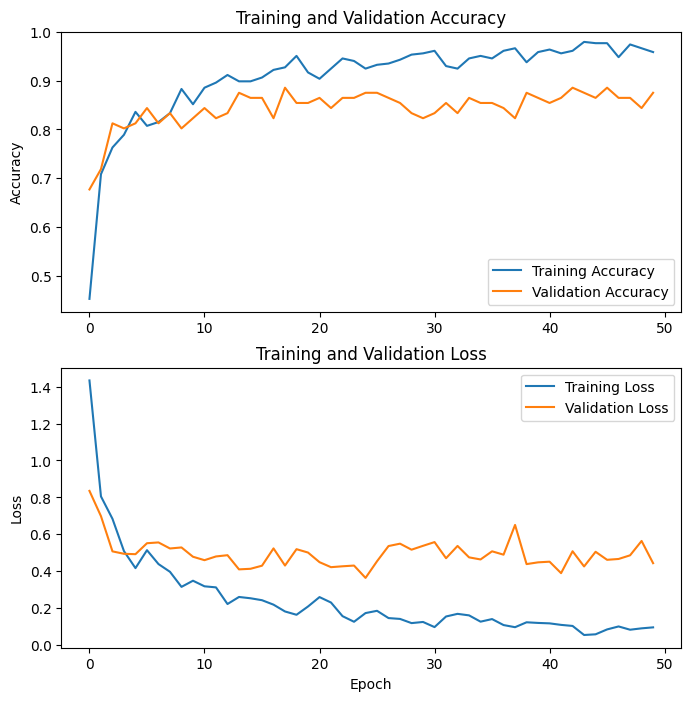

Training Results:
~Accuracy~
Max (best) accuracy: 0.9791666865348816 at epoch 44
Min (worst) accuracy: 0.453125 at epoch 1
Median accuracy: 0.93359375
Mean accuracy: 0.9069270825386048

~Loss~
Min (best) loss: 0.055259495973587036 at epoch 44
Max (worst) loss: 1.433110237121582 at epoch 1
Median loss: 0.16309424489736557
Mean loss: 0.24269336894154547

~Final Training Performance~
Accuracy: 0.9791666865348816, Loss: 0.051216717809438705

Validation Results:
~Accuracy~
Max (best) accuracy: 0.8854166865348816 at epoch 18
Min (worst) accuracy: 0.6770833134651184 at epoch 1
Median accuracy: 0.8541666865348816
Mean accuracy: 0.8439583313465119

~Loss~
Min (best) loss: 0.36421409249305725 at epoch 25
Max (worst) loss: 0.8353045582771301 at epoch 1
Median loss: 0.486898735165596
Mean loss: 0.4953438287973404

~Final Validation Performance~
Accuracy: 0.875, Loss: 0.4440337121486664


In [29]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

# Visualize model performance
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(val_ds, verbose=0)))

{'accuracy': 0.875, 'recall': 0.9736842, 'precision': 0.9866667, 'f1_score': 0.9801324605941772}


2024-07-09 17:08:48.590052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


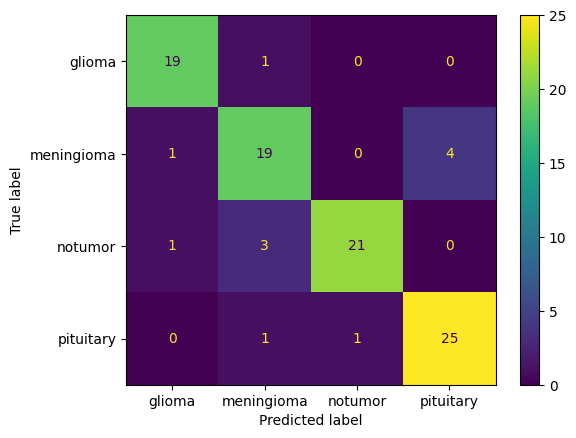

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(val_ds, verbose=0)
y_pred = [np.argmax(tf.nn.softmax(prediction)) for prediction in predictions]
y_true = [label for _, label in val_ds.unbatch().as_numpy_iterator()]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot()

# Computing Metrics
def show_metrics(y_true, y_pred):
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    accuracy = tf.keras.metrics.Accuracy()

    recall.update_state(y_true, y_pred)
    precision.update_state(y_true, y_pred)
    accuracy.update_state(y_true, y_pred)

    f1_score = 2 * ((recall.result().numpy() * precision.result().numpy()) / (recall.result().numpy() + precision.result().numpy()))
    
    return {
        'accuracy': accuracy.result().numpy(),
        'recall': recall.result().numpy(),
        'precision': precision.result().numpy(),
        'f1_score': f1_score
    }

validation_metrics = show_metrics(y_true, y_pred)
print(validation_metrics)

In [31]:
def metrics2dt(acc, rc, pr, f1):
    return pd.DataFrame(data={"Accuracy":acc, "Recall":rc, "Precision":pr, "F1-Score":f1}, index=[0])

def show_metrics(y_true, y_pred):
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    accuracy = tf.keras.metrics.Accuracy()

    recall.update_state(y_true, y_pred)
    recall = recall.result().numpy()
    
    precision.update_state(y_true, y_pred)
    precision = precision.result().numpy()
    
    accuracy.update_state(y_true, y_pred)
    accuracy = accuracy.result().numpy()
    
    f1_score = 0
    if recall+precision != 0:
        f1_score = 2 * ((recall*precision)/(recall+precision))
    
    return metrics2dt(accuracy, recall, precision, f1_score)

validation_metrics = show_metrics(y_true,y_pred)
validation_metrics

,Accuracy,Recall,Precision,F1-Score
0,0.875,0.973684,0.986667,0.980132


# Model Evaluation

### K-Fold Cross-Validation - No re-initialisation after each fold 

In [32]:
from sklearn.model_selection import StratifiedKFold, KFold

""" K-Fold Cross-Validation """
# Load dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []
list_skf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

Found 480 files belonging to 4 classes.


2024-07-09 17:08:50.920928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 0.9817708134651184, Loss: 0.038635317236185074
~Validation Dataset~
Accuracy: 0.9166666865348816, Loss: 0.21855461597442627

Fold Index 1
~Training Dataset~
Accuracy: 0.9869791865348816, Loss: 0.03597383573651314
~Validation Dataset~
Accuracy: 0.9479166865348816, Loss: 0.1093207597732544

Fold Index 2
~Training Dataset~
Accuracy: 0.9921875, Loss: 0.013009185902774334
~Validation Dataset~
Accuracy: 1.0, Loss: 0.010314393788576126

Fold Index 3
~Training Dataset~
Accuracy: 0.9895833134651184, Loss: 0.03164098411798477
~Validation Dataset~
Accuracy: 0.96875, Loss: 0.06715956330299377

Fold Index 4
~Training Dataset~
Accuracy: 0.9869791865348816, Loss: 0.02998513914644718
~Validation Dataset~
Accuracy: 0.9583333134651184, Loss: 0.11705590039491653



In [33]:
import json
# Calculate statistics
def calculate_statistics(data):
    return {
        'max': np.max(data),
        'min': np.min(data),
        'median': np.median(data),
        'mean': np.mean(data)
    }

print("K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_kf_results]
train_losses = [result['train_loss'] for result in list_kf_results]
val_accuracies = [result['val_accuracy'] for result in list_kf_results]
val_losses = [result['val_loss'] for result in list_kf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 0.9921875,
        "min": 0.9817708134651184,
        "median": 0.9869791865348816,
        "mean": 0.9875
    },
    "Training Loss": {
        "max": 0.038635317236185074,
        "min": 0.013009185902774334,
        "median": 0.03164098411798477,
        "mean": 0.0298488924279809
    },
    "Validation Accuracy": {
        "max": 1.0,
        "min": 0.9166666865348816,
        "median": 0.9583333134651184,
        "mean": 0.9583333373069763
    },
    "Validation Loss": {
        "max": 0.21855461597442627,
        "min": 0.010314393788576126,
        "median": 0.1093207597732544,
        "mean": 0.10448104664683341
    }
}


### K-Fold Cross-Validation - Re-initialisation after each fold 

In [34]:
# Define a function to build the model
def build_model():
    base_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = False
    model = Sequential([
        tf.keras.layers.Resizing(224, 224),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.25),
        tf.keras.layers.RandomZoom(0.05, 0.05),
        tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation="softmax")
    ])
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=Adam(learning_rate= lr),
        metrics=["accuracy"]
    )
    return model


In [35]:
# Load the dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Convert dataset to numpy arrays for k-fold splitting
images, labels = [], []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Build and train the model
    model = build_model()
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "history": history.history
    })
    
    print(f"Fold {fold_no}")
    print(f"~Training Dataset~\nAccuracy: {train_accuracy}, Loss: {train_loss}")
    print(f"~Validation Dataset~\nAccuracy: {val_accuracy}, Loss: {val_loss}\n")
    
    # Increment fold number
    fold_no += 1

Found 480 files belonging to 4 classes.


2024-07-09 17:20:03.610835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


K-Fold Cross-Validation
Fold 0
~Training Dataset~
Accuracy: 0.9453125, Loss: 0.14081625640392303
~Validation Dataset~
Accuracy: 0.8125, Loss: 0.6686801910400391

Fold 1
~Training Dataset~
Accuracy: 0.9348958134651184, Loss: 0.1546953022480011
~Validation Dataset~
Accuracy: 0.8645833134651184, Loss: 0.3807194232940674

Fold 2
~Training Dataset~
Accuracy: 0.9765625, Loss: 0.10116002708673477
~Validation Dataset~
Accuracy: 0.90625, Loss: 0.2429775446653366

Fold 3
~Training Dataset~
Accuracy: 0.9479166865348816, Loss: 0.12789300084114075
~Validation Dataset~
Accuracy: 0.875, Loss: 0.3843716084957123

Fold 4
~Training Dataset~
Accuracy: 0.9244791865348816, Loss: 0.1685425043106079
~Validation Dataset~
Accuracy: 0.84375, Loss: 0.47338899970054626



In [36]:
# Calculate statistics
def calculate_statistics(data):
    return {
        'max': np.max(data),
        'min': np.min(data),
        'median': np.median(data),
        'mean': np.mean(data)
    }

print("K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_kf_results]
train_losses = [result['train_loss'] for result in list_kf_results]
val_accuracies = [result['val_accuracy'] for result in list_kf_results]
val_losses = [result['val_loss'] for result in list_kf_results]

# Print results
import json
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 0.9765625,
        "min": 0.9244791865348816,
        "median": 0.9453125,
        "mean": 0.9458333373069763
    },
    "Training Loss": {
        "max": 0.1685425043106079,
        "min": 0.10116002708673477,
        "median": 0.14081625640392303,
        "mean": 0.13862141817808152
    },
    "Validation Accuracy": {
        "max": 0.90625,
        "min": 0.8125,
        "median": 0.8645833134651184,
        "mean": 0.8604166626930236
    },
    "Validation Loss": {
        "max": 0.6686801910400391,
        "min": 0.2429775446653366,
        "median": 0.3843716084957123,
        "mean": 0.43002755343914034
    }
}
